In [3]:
# importing libraries
!git clone https://github.com/zz4fap/t319_aprendizado_de_maquina.git
import sys
sys.path.insert(0,'./t319_aprendizado_de_maquina/projeto/')
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.linear_model import Lasso

fatal: destination path 't319_aprendizado_de_maquina' already exists and is not an empty directory.


In [9]:
def generateDatasets3(N):
    # Attribute.
    x_train = np.sort(3*np.random.rand(N, 1) - 1.5, axis=0)
    # True function.
    y_train = 1 + x_train + 0.5*x_train**2 - 1.5*x_train**3
    # Observable function.
    y_train_noisy = y_train + np.random.randn(N, 1)
    
    # Attribute.
    N = 50
    x_test = np.linspace(-1.5,1.5,N).reshape(N,1)
    # True function.
    y_test = 1 + x_test + 0.5*x_test**2 - 1.5*x_test**3
    # Observable function.
    y_test_noisy = y_test + np.random.randn(N, 1)    
    
    return x_train, y_train, y_train_noisy, x_test, y_test_noisy

def gradientDescentMiniBatch(X_train, y_train_noisy, X_test, y_test_noisy, alpha, n_epochs, N, mb_size, seed):
    '''
    Função que implementa o algoritmo do gradiente descendente em mini-batches.
    Parâmetros de entrada:
       X_train: matriz de atributos de treinamento
       y_train_noisy: vetor de rótulos de treinamento (ou valores esperados)
       X_test: matriz de atributos de validação
       y_test_noisy: vetor de rótulos de validação (ou valores esperados) 
       alpha: passo de aprendizagem
       n_epochs: número máximo de épocas
       N: número de exemplos do conjunto de treinamento
       mb_size: tamanho do mini-batch
    '''
    # Reset PN sequence generators.
    np.random.seed(seed)
    random.seed(seed)

    # Define the initial minimum error.
    error_min = float("inf")
    
    # Random initialization of parameters.
    a = np.random.randn(X_train.shape[1], 1)

    # Create vector for parameter history.
    a_hist = np.zeros((X_train.shape[1], n_epochs*(N//mb_size)+1))
    # Initialize history vector.
    a_hist[:, 0] = a.reshape(X_train.shape[1],)

    # Create array for storing error values.
    Jgd_train = np.zeros(n_epochs*(N//mb_size)+1)
    Jgd_test = np.zeros(n_epochs*(N//mb_size)+1)

    Jgd_train[0] = (1.0/N)*sum(np.power(y_train_noisy - X_train.dot(a), 2))
    Jgd_test[0] = (1.0/N)*sum(np.power(y_test_noisy - X_test.dot(a), 2))

    # Create array for storing gradient values.
    grad_hist = np.zeros((X_train.shape[1], n_epochs*(N//mb_size)))

    # Mini-batch gradient-descent loop.
    inc = 0
    for e in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_data_set_indexes = random.sample(range(0, N), N)

        for i in range(0, N//mb_size):

            start = i*mb_size
            end = mb_size*(i+1)
            batch_indexes = shuffled_data_set_indexes[start:end]

            xi = X_train[batch_indexes]
            yi = y_train_noisy[batch_indexes]

            gradients = -(2.0/mb_size)*xi.T.dot(yi - xi.dot(a))
            a = a - alpha*gradients

            Jgd_train[inc+1] = (1.0/N)*sum(np.power((y_train_noisy - X_train.dot(a)), 2))
            Jgd_test[inc+1] = (1.0/N)*sum(np.power((y_test_noisy - X_test.dot(a)), 2))
            
            if(Jgd_test[inc+1] < error_min):
                error_min = Jgd_test[inc+1]
                a_min = a
                inc_min = inc
            
            grad_hist[:, inc] = gradients.reshape(X_train.shape[1],)
            a_hist[:, inc+1] = a.reshape(X_train.shape[1],)

            inc = inc + 1
            
    return a, Jgd_train, Jgd_test, a_hist, grad_hist, inc, error_min, a_min, inc_min

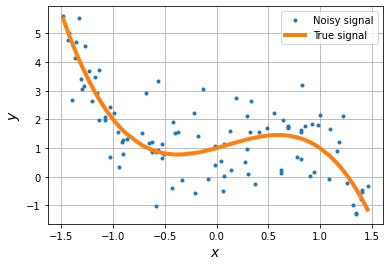

In [10]:
# Reset PN sequence generator.
seed = 42
np.random.seed(seed)
random.seed(seed)

# Number of examples.
N = 100

# Generate dataset.
x_train, y_train, y_train_noisy, x_test, y_test_noisy = generateDatasets3(N)

# Plot comparison between true and noisy model.
plt.plot(x_train, y_train_noisy, '.', label='Noisy signal')
plt.plot(x_train, y_train, label='True signal', linewidth=4)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.grid()
plt.legend()
plt.show()

Se ao executar a função `gradientDescentMiniBatch` você encontrar o warning: `RuntimeWarning: overflow encountered in power`, diminua o valor do passo de aprendizagem.

In [11]:
degree = 30
include_bias = True
n_epochs = 100000
mb_size = N
alpha = 0.003

# Transform attribute vector into polynomial attribute matrix.
poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
X_train_poly = poly.fit_transform(x_train)
X_test_poly = poly.fit_transform(x_test)

# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
X_train = np.c_[np.ones((N,1)), scaler.fit_transform(X_train_poly[:,1:])]
X_test = np.c_[np.ones((int(N/2),1)), scaler.transform(X_test_poly[:,1:])]

a, Jgd_train, Jgd_test, a_hist, grad_hist, inc, error_min, a_min, inc_min = gradientDescentMiniBatch(X_train, y_train_noisy, X_test, y_test_noisy, alpha, n_epochs, N, mb_size, seed)

In [12]:
print(np.argwhere(Jgd_test == min(Jgd_test))[0][0])
print(inc_min)
print(error_min)

100000
99999
0.7083053326644728


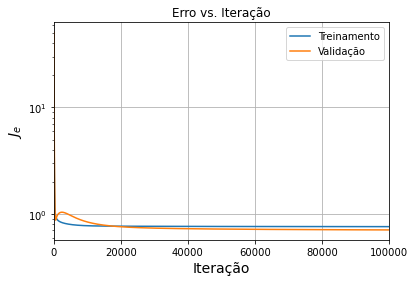

In [13]:
# Plot contour figure.        
fig = plt.figure()
plt.plot(np.arange(0, inc+1), Jgd_train[0:inc+1], label='Treinamento')
plt.plot(np.arange(0, inc+1), Jgd_test[0:inc+1], label='Validação')
plt.xlim((0, inc+1))
plt.yscale('log')
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Erro vs. Iteração')
plt.legend()
plt.grid()

if(0):
    maxX = 2000
    left, bottom, width, height = [0.2, 0.5, 0.3, 0.3]
    ax1 = fig.add_axes([left, bottom, width, height])
    ax1.plot(np.arange(0, maxX), Jgd_train[0:maxX])
    ax1.plot(np.arange(0, maxX), Jgd_test[0:maxX])
    ax1.grid()
    ax1.set_yscale('log')
    #ax1.set_ylim(0, maxY)

plt.show()

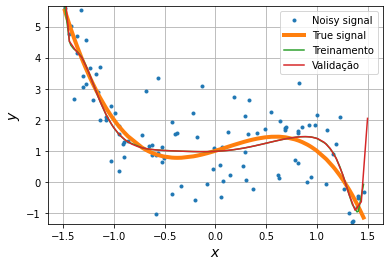

In [14]:
y_train_pred_min = X_train.dot(a_min)
y_test_pred_min = X_test.dot(a_min)

# Plot comparison between true and noisy model.
plt.plot(x_train, y_train_noisy, '.', label='Noisy signal')
plt.plot(x_train, y_train, label='True signal', linewidth=4)
plt.plot(x_train, y_train_pred_min, label='Treinamento')
plt.plot(x_test, y_test_pred_min, label='Validação')
plt.ylim(min(y_train_noisy)-0.05, max(y_train_noisy)+0.05)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.grid()
plt.legend()
plt.show()